In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    ExpCutoffPowerLawNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

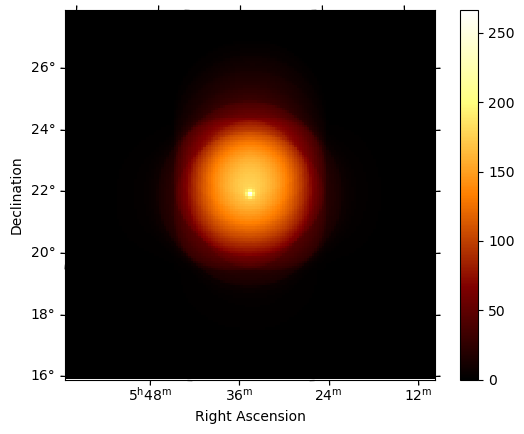

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Single Cases

In [4]:
sigmas = np.linspace(0,0.1,6)
sigmas = np.insert(sigmas, 0, -0.05) # Standard dataset, but plot on the left this way
sigmas[1] = 1e-25 # cannot put 0 in it --> 1/ 0 = np.nan
factor_pos = +0.1
labels_x = ['Standard'] + [str(i) for i in sigmas[1:]]
#labels_x[4] = str(0.15)
print(sigmas)

[-5.e-02  1.e-25  2.e-02  4.e-02  6.e-02  8.e-02  1.e-01]


In [5]:
datasets = []
for i, sigma in enumerate(sigmas):
    sys = sys_dataset(dataset_asimov, factor_pos,False )
    data = sys.create_dataset_N()
    penalising_covmatrix = [[1/sigma**2, 0, 0], [0, 1/sigma**2, 0], [0, 0, 1/sigma**2]]
    penalising_invcovmatrix =  penalising_covmatrix
    data.penalising_invcovmatrix = penalising_invcovmatrix
    if i ==0:
        data.models.parameters['amplitude_nuisance'].frozen = True
    datasets.append(data)     

In [6]:
fitting = False

if fitting:
    for i, dataset in enumerate(datasets):
        print("Fitting dataset number ", i, " ... ", sigmas[i])
        print("Stat sum before ",  dataset.stat_sum())
        
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run(dataset)
        print("Stat sum after ",  dataset.stat_sum())
        
    nui_all_N = []
    nui_err_all_N = []
    norm_all_N = []
    norm_err_all_N = []
    amplitude_all_N = []
    amplitude_err_all_N = []
    stat_all_N = []
    
    
    for dataset in datasets:
        nui_all_N.append(float(dataset.models.parameters['amplitude_nuisance'].value))
        nui_err_all_N.append(float(dataset.models.parameters['amplitude_nuisance'].error))
        norm_all_N.append(float(dataset.models.parameters['norm'].value))
        norm_err_all_N.append(float(dataset.models.parameters['norm'].error))
        amplitude_all_N.append(float(dataset.models.parameters['amplitude'].value))
        amplitude_err_all_N.append(float(dataset.models.parameters['amplitude'].error))
        stat_all_N.append(float(dataset.stat_sum()))
        
                          
    print("saving ... ")    
    with open('data/4_nui_all_N.yaml', 'w') as file:
        documents = yaml.dump(nui_all_N, file)
    with open('data/4_nui_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(nui_err_all_N, file)
    with open('data/4_nui_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(nui_err_all_N, file)
    with open('data/4_norm_all_N.yaml', 'w') as file:
        documents = yaml.dump(norm_all_N, file)
    with open('data/4_norm_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(norm_err_all_N, file)
    with open('data/4_amplitude_all_N.yaml', 'w') as file:
        documents = yaml.dump(amplitude_all_N, file)
    with open('data/4_amplitude_err_all_N.yaml', 'w') as file:
        documents = yaml.dump(amplitude_err_all_N, file)
    with open('data/4_stat_all_N.yaml', 'w') as file:
        documents = yaml.dump(stat_all_N, file)

Fitting dataset number  0  ...  -0.05
Stat sum before  -752489.3086654372
Stat sum after  -752490.7654616862
Fitting dataset number  1  ...  1e-25
Stat sum before  -752489.3086654372
Stat sum after  -752490.7659136899
Fitting dataset number  2  ...  0.02
Stat sum before  -752489.3086654372
Stat sum after  -752490.7653846451
Fitting dataset number  3  ...  0.04
Stat sum before  -752489.3086654372
Stat sum after  -752490.7657041587
Fitting dataset number  4  ...  0.06
Stat sum before  -752489.3086654372
Stat sum after  -752490.7659075821
Fitting dataset number  5  ...  0.08
Stat sum before  -752489.3086654372
Stat sum after  -752490.7659106731
Fitting dataset number  6  ...  0.1
Stat sum before  -752489.3086654372
Stat sum after  -752490.7660743295
saving ... 


In [7]:
if fitting == False:
    print("reading ... ")    
    
    with open('data/4_nui_all_N.yaml') as file:
        nui_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_nui_err_all_N.yaml') as file:
        nui_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_norm_all_N.yaml') as file:
        norm_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_norm_err_all_N.yaml') as file:
        norm_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_amplitude_all_N.yaml') as file:
        amplitude_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_amplitude_err_all_N.yaml') as file:
        amplitude_err_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/4_stat_all_N.yaml') as file:
        stat_all_N = yaml.load( file, Loader=yaml.FullLoader)


Text(0.5, 0, 'Penalty Sigma')

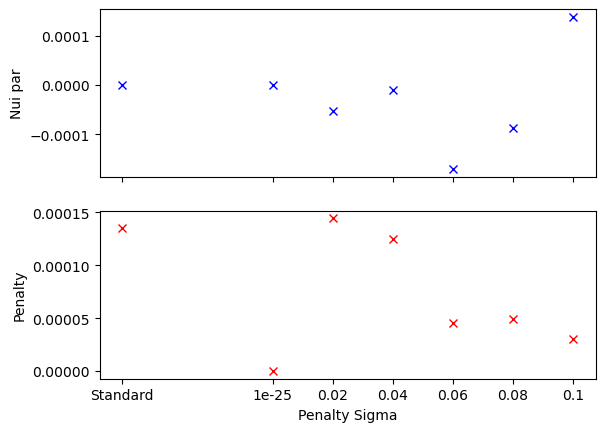

In [8]:
from gammapy.datasets.map import gaussian_penality #redirected from usual stats because of windows
fig , axs = plt.subplots(2,1, sharex=True)

for i, d in enumerate(datasets):
    axs[0].plot(sigmas[i], nui_all_N[i], 'x', color = 'blue')
    pen = nui_all_N[i]**2 / sigmas[i] ** 2
    pen = gaussian_penality(d.models.parameters.penalised_parameters, 
                            d.penalising_invcovmatrix)
    axs[1].plot(sigmas[i], pen, 'x', color = 'red')
axs[0].set_xticks(sigmas,labels_x)    
axs[1].set_xticks(sigmas,labels_x)    
axs[0].set_ylabel("Nui par")
axs[1].set_ylabel("Penalty")
axs[1].set_xlabel("Penalty Sigma")

Text(0.5, 0, 'Penalty Sigma')

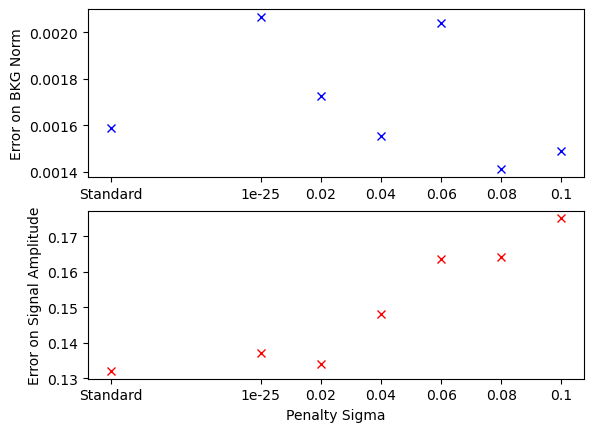

In [9]:
fig , axs = plt.subplots(2,1)

for i, d in enumerate(datasets):
    axs[0].plot(sigmas[i], norm_err_all_N[i], 'x', color = 'blue')
    axs[1].plot(sigmas[i], np.array(amplitude_err_all_N[i])/1e-12, 'x', color = 'red')
axs[0].set_xticks(sigmas,labels_x)    
axs[1].set_xticks(sigmas,labels_x)    
axs[0].set_ylabel("Error on BKG Norm")
axs[1].set_ylabel("Error on Signal Amplitude")
axs[1].set_xlabel("Penalty Sigma")

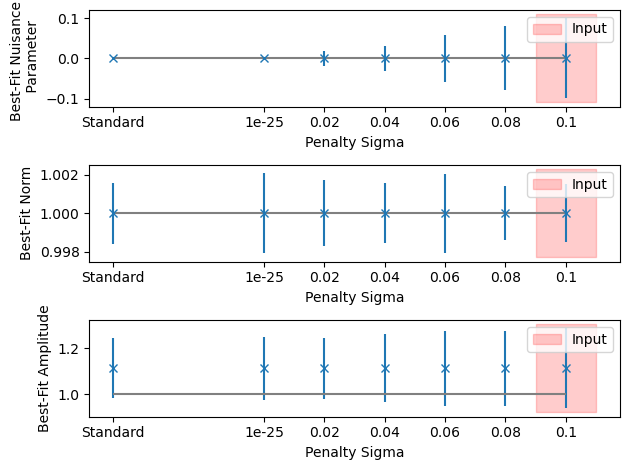

In [10]:
fig,ax = plt.subplots(3,1)

ax[0].errorbar(x = sigmas, y = nui_all_N, yerr= nui_err_all_N,  fmt='x', )
ax[0].set_xlabel("Penalty Sigma")
ax[0].set_ylabel("Best-Fit Nuisance \n Parameter")
ax[0].hlines(0, np.min(sigmas),np.max(sigmas), label = "", color = 'grey')
ax[0].fill_between(  [factor_pos- 0.01, factor_pos+0.01], ax[0].get_ylim()[0], ax[0].get_ylim()[1],
                  label = "Input", color = 'red', alpha = 0.2)

ax[1].errorbar(x = sigmas, y = norm_all_N, yerr= norm_err_all_N,  fmt='x', )
ax[1].set_xlabel("Penalty Sigma")
ax[1].set_ylabel("Best-Fit Norm")
ax[1].hlines(1, np.min(sigmas),np.max(sigmas), label = "", color = 'grey')
ax[1].fill_between(  [factor_pos- 0.01, factor_pos+0.01], ax[1].get_ylim()[0], ax[1].get_ylim()[1],
                  label = "Input", color = 'red', alpha = 0.2)

ax[2].errorbar(x = sigmas, y = np.array(amplitude_all_N) /1e-12, yerr= np.array(amplitude_err_all_N) /1e-12,
               fmt='x', )
ax[2].set_xlabel("Penalty Sigma")
ax[2].set_ylabel("Best-Fit Amplitude")
ax[2].hlines(1, np.min(sigmas),np.max(sigmas), label = "", color = 'grey')
ax[2].fill_between(  [factor_pos- 0.01, factor_pos+0.01], ax[2].get_ylim()[0], ax[2].get_ylim()[1],
                  label = "Input", color = 'red', alpha = 0.2)

for axx in ax:
    axx.legend()
    axx.set_xticks(sigmas,labels_x)    
plt.tight_layout()
fig.savefig("plots/4_nui_vs_sigma.png")